In [78]:
import csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [79]:
# Settings
PATH = '.' # if running locally
# PATH = '/home/lmacy1/predictiveml' # if running on ARCC
data_path = f'{PATH}/clean_data_extended'
buildings_list = ['Stadium_Data_Extended.csv']
save_model_file = False
save_model_plot = True
min_number_of_days = 365
memory_limit = 102400
exclude_column = 'present_co2_tons'

y_columns = ['present_elec_kwh', 'present_htwt_mmbtu', 'present_wtr_usgal', 'present_chll_tonhr', 'present_co2_tons']
add_features = ['temp_c', 'rel_humidity_%', 'surface_pressure_hpa', 'cloud_cover_%', 'direct_radiation_w/m2', 'precipitation_mm', 'wind_speed_ground_km/h', 'wind_dir_ground_deg']

# Training scope
models = {}
model_types = ['ensembles', 'solos']
preprocessing_methods = ['arima']
feature_modes = ['rfe', 'lasso']

# Hyperparameters
n_features_list = list(range(1, len(add_features)))
n_folds = 5
time_steps = [1, 8, 12, 24]
minutes_per_model = 2
split_rate = 0.8

for model_type in model_types:
    out_path = f'{PATH}/models/{model_type}/'

    for building in buildings_list:
        df = pd.read_csv(f'{data_path}/{building}')

        # Convert the data into a Pandas dataframe
        df['ts'] = pd.to_datetime(df['ts'])
        df = df.drop_duplicates(subset=['bldgname', 'ts'])
        df = df.sort_values(['bldgname', 'ts'])

        # Group the dataframe by building name and timestamp
        groups = df.groupby('bldgname')
        df = df.set_index('ts')
        header = ['ts'] + y_columns + add_features

        print(building)

        # cycle through building names if more than one building per file
        for name, group in groups:
            bldgname = name
            group = group.drop_duplicates(subset=['ts'])

            # cycle through commodities
            for y in y_columns:

                col_data = group[header]

                # check if column contains the min number of days and is a valid commodity to train on
                if col_data[y].count() >= min_number_of_days * 24 and y != exclude_column:

                    # cycle through preprocessing methods
                    for preprocessing_method in preprocessing_methods:

                        model_data = col_data.copy()
                        model_data = model_data.rename(columns={ y: 'y', 'ts': 'ds' })
                        model_data = model_data.sort_values(['ds'])

                        # save the original values into new column

                        # Fill in missing values (Preprocessing)
                        
                        # *** ARIMA (daily seasonality, m=24) (5/5) ***

                        # m = auto_arima(model_data[model_data['y'].notna()]['y'].values, seasonal=True, m=24*365, suppress_warnings=False)

                        # y_pred, conf_int = m.predict(n_periods=model_data['y'].isna().sum())
                        # model_data.loc[model_data['y'].isna(), 'y'] = y_pred


                        break
                    break
                break
            break
        break
    break

                        

Stadium_Data_Extended.csv


In [80]:
df = model_data.copy()
model_data['y_saved'] = df['y']
model_data['y'] = df['y']

In [81]:
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds')
# df= df.sort_index()
df = df.asfreq('H')
# df = dfa['y'].dropna()
df.head()

,y,present_htwt_mmbtu,present_wtr_usgal,present_chll_tonhr,present_co2_tons,temp_c,rel_humidity_%,surface_pressure_hpa,cloud_cover_%,direct_radiation_w/m2,precipitation_mm,wind_speed_ground_km/h,wind_dir_ground_deg
ds,,,,,,,,,,,,,
2019-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN,12.2,53.0,779.9,0.0,0.0,0.0,15.6,165.0
2019-09-19 01:00:00,NaN,NaN,NaN,NaN,NaN,11.6,54.0,779.3,0.0,0.0,0.0,13.4,172.0
2019-09-19 02:00:00,NaN,NaN,NaN,NaN,NaN,10.9,57.0,778.2,0.0,0.0,0.0,11.2,178.0
2019-09-19 03:00:00,NaN,NaN,NaN,NaN,NaN,10.3,60.0,777.3,0.0,0.0,0.0,9.1,189.0
2019-09-19 04:00:00,NaN,NaN,NaN,NaN,NaN,9.7,62.0,776.8,0.0,0.0,0.0,8.0,185.0


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Total Consumption')]

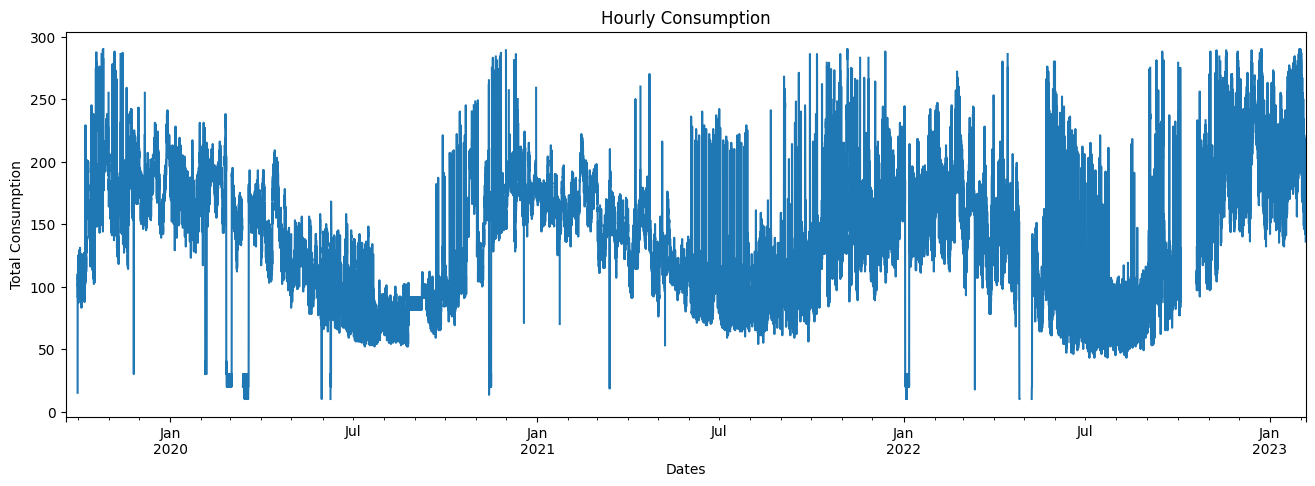

In [82]:
#Basic Data Plot
df.index.freq = 'H'
ax = df['y'].plot(figsize = (16,5), title = "Hourly Consumption")
ax.set(xlabel='Dates', ylabel='Total Consumption')

In [83]:
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import numpy as np
# import pandas as pd

# # Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(model_data["y"].values.reshape(-1, 1))

# # Train the model on the entire model_data
# window_size = 2

# def create_model_data(model_data, window_size):
#     X, y = [], []
#     for i in range(window_size, len(model_data)):
#         X.append(model_data[i-window_size:i, 0])
#         y.append(model_data[i, 0])
#     X, y = np.array(X), np.array(y)
#     return X, y

# X_train, y_train = create_model_data(data_scaled, window_size)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# model = Sequential()
# model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dense(units=1))

# model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)

# model.fit(X_train, y_train, epochs=3, batch_size=32)

# # Find the unique indices of missing values in model_data['y']
# missing_indices = np.unique(model_data['y'].index[model_data['y'].isnull()])

# # Create the input for predicting the missing values
# X_missing = []

# for idx in missing_indices:
#     X_missing.append(data_scaled[idx - window_size:idx, 0])

# X_missing = pad_sequences(X_missing, maxlen=window_size, dtype='float32', padding='post')

# # Predict the missing values
# y_pred = model.predict(X_missing)

# # Inverse transform the predictions
# y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

# # Replace the missing values in model_data['y'] with the predicted values
# missing_indices_sorted = np.argsort(missing_indices)  # Sort missing indices
# y_pred_inverse_sorted = y_pred_inverse[missing_indices_sorted]  # Sort predicted values accordingly

# model_data.loc[model_data['y'].isnull(), 'y'] = y_pred_inverse_sorted.flatten()


In [84]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# hyperparameters
window_size = 24
epochs = 3

# Fill in missing values temporarily
y_int = model_data['y'].interpolate(method='linear', limit_direction='both')
y_clean = model_data['y'].dropna()

# Find the unique indices of missing values in model_data['y']
missing_indices = np.unique(model_data['y'].index[model_data['y'].isnull()])

missing_gaps = []
group = []

for i, value in enumerate(model_data['y']):
    if np.isnan(value):
        group.append(i)
    elif len(group) > 0:
        missing_gaps.append(group)
        group = []

if len(group) > 0:
    missing_gaps.append(group)

print(f'# of gaps: {len(missing_gaps)}')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(y_clean.values.reshape(-1, 1))

# Train the model on the entire model_data
def create_model_data(model_data, window_size):
    X, y = [], []
    for i in range(window_size, len(model_data)):
        X.append(model_data[i-window_size:i, 0])
        y.append(model_data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = create_model_data(data_scaled, window_size)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)
early_stopping = EarlyStopping(monitor='loss', patience=epochs)  # Define early stopping criteria

model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[early_stopping])

# of gaps: 163


2023-06-03 13:35:55.376214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 13:35:55.377948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 13:35:55.379433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3


2023-06-03 13:35:55.829454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 13:35:55.831433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 13:35:55.832961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

881/881 [==============================] - 243s 276ms/step - loss: 0.0122
Epoch 2/3
881/881 [==============================] - 242s 275ms/step - loss: 0.0086
Epoch 3/3
881/881 [==============================] - 240s 272ms/step - loss: 0.0078


1/1 [==============================] - 0s 126ms/step


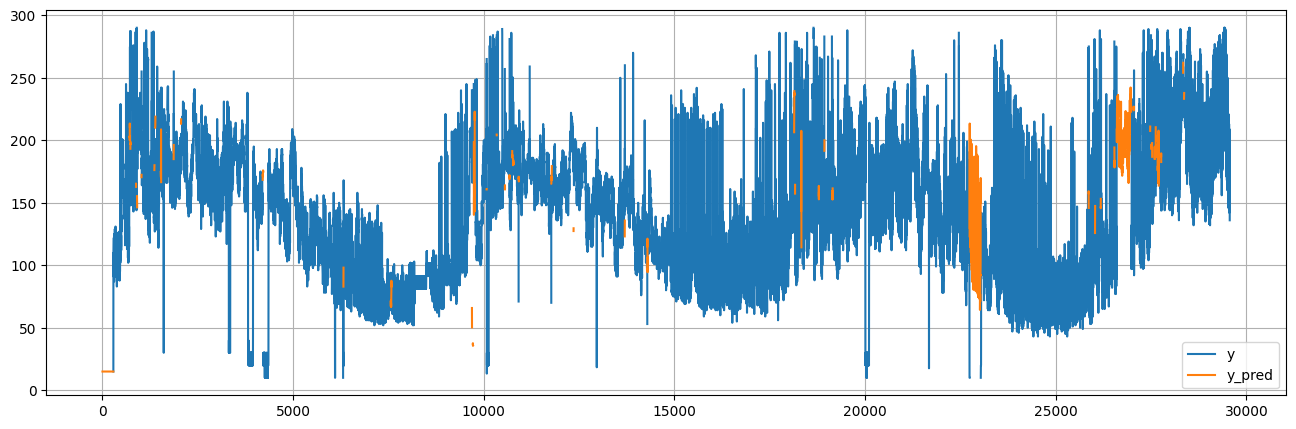

In [112]:
# Generate predictions for each gap and replace in model_data['y']
for gaps in missing_gaps:
    for i in range(0, len(gaps), window_size):
        sub_gaps = gaps[i:i+window_size]
        start_index = sub_gaps[0]
        end_index = sub_gaps[-1]
        gap_length = end_index - start_index + 1

        # Create input sequence for the sub-gap
        X_pred_gap, _ = create_model_data(data_scaled, window_size)
        X_pred_gap = X_pred_gap[start_index-window_size:end_index]
        X_pred_gap = np.reshape(X_pred_gap, (X_pred_gap.shape[0], X_pred_gap.shape[1], 1))

        # Check if the sub-gap is long enough for making predictions or if there are gaps at the start or end of the data
        if X_pred_gap.shape[0] < window_size - 1 or gaps[0] == 0 or gaps[-1] == len(model_data) - 1:
            # Fill in the remaining gaps using interpolation
            model_data['y'].iloc[model_data['y'].index[start_index:end_index+1]] = y_int.iloc[start_index:end_index+1].values
        else:
            # Generate prediction for the sub-gap
            y_pred_gap = model.predict(X_pred_gap)
            y_pred = scaler.inverse_transform(y_pred_gap.reshape(-1, 1))

            # Replace the sub-gap in model_data['y'] with the predicted values
            model_data['y'].iloc[model_data['y'].index[start_index:end_index+1]] = y_pred[:gap_length].reshape(-1)

# # Apply interpolation to fill in remaining gaps
# model_data['y'] = model_data['y'].interpolate(method='linear', limit_direction='both')

y = model_data['y'].copy()
# print(len(y))
y_saved = model_data['y_saved'].copy()
# print(len(y_saved))
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y_saved, label='y')

nan_mask = np.isnan(y_saved)  # boolean mask of NaN values in saved_y
y[~nan_mask] = np.nan

ax.plot(y, label='y_pred')
ax.legend()
plt.grid(True)

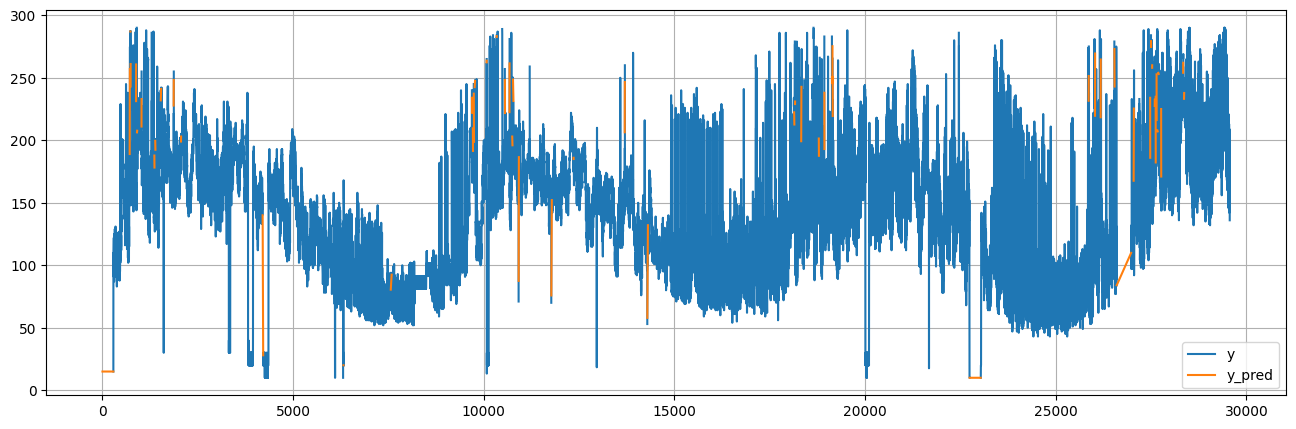

In [86]:
# Compare graph with interpolation technique
y = model_data['y_saved'].interpolate(method='linear', limit_direction='both')    
y_saved = model_data['y_saved']

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y_saved, label='y')

nan_mask = np.isnan(y_saved)  # boolean mask of NaN values in saved_y
y[~nan_mask] = np.nan

ax.plot(y, label='y_pred')
ax.legend()
plt.grid(True)